Data Gathering

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.optim
import torch.nn.functional as F
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import seaborn as sns
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

In [2]:
# added comments to only things changed from last submitted project file (epsilon2)

current_dir = os.getcwd()
root_dir = os.path.join(current_dir, "input")
image_paths = []
vehicle_types = []
vehicle_colors = []
vehicle_subtypes = []
arrimg = []
vt_encoder = LabelEncoder()
vst_encoder = LabelEncoder()
vc_encoder = LabelEncoder()

for filename in os.listdir(root_dir):
    if filename.endswith('.png'):
        parts = filename.split('_') 
        vehicle_type, vehicle_subtype = parts[3].split('.')[0], parts[3].split('.')[1] 
        vehicle_color = parts[4]

        image_path = os.path.join(root_dir, filename) 
        img = (Image.open(image_path))
        arrimg.append(np.asarray(img))

        vehicle_types.append(vehicle_type)
        vehicle_subtypes.append(vehicle_subtype)
        vehicle_colors.append(vehicle_color)

df = pd.DataFrame({
    'image': arrimg,
    'vehicle_type': vehicle_types,
    'vehicle_subtype': vehicle_subtypes,
    'vehicle_color': vehicle_colors})

df['vehicle_type'] = vt_encoder.fit_transform(df['vehicle_type'])
df['vehicle_subtype'] = vst_encoder.fit_transform(df['vehicle_subtype'])
df['vehicle_color'] = vc_encoder.fit_transform(df['vehicle_color'])

Data preprocessing

In [11]:
class MakeDataset(Dataset):
    def __init__(self, image, vehicle_type, vehicle_subtype, vehicle_color, transform=None):
        self.image = image
        self.vehicle_type = vehicle_type
        self.vehicle_subtype = vehicle_subtype
        self.vehicle_color = vehicle_color
        self.transform = transform

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        image = self.image[idx]
        vehicle_type = self.vehicle_type[idx]
        vehicle_subtype = self.vehicle_subtype[idx]
        vehicle_color = self.vehicle_color[idx]

        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        vehicle_type_label = torch.tensor(vehicle_type, dtype=torch.long)
        vehicle_subtype_label = torch.tensor(vehicle_subtype, dtype=torch.long)
        vehicle_color_label = torch.tensor(vehicle_color, dtype=torch.long)

        return image, (vehicle_type_label, vehicle_subtype_label, vehicle_color_label)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.2)
]) # added 2 more transformations, random horizontal and vertical flip, percentages were random

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)

train_df = train_df.reset_index(drop=True)
temp_df = temp_df.reset_index(drop=True)

dataset1 = MakeDataset(image=train_df.image, vehicle_type=train_df.vehicle_type, vehicle_subtype=train_df.vehicle_subtype, vehicle_color=train_df.vehicle_color, transform=train_transform)
datasettemp = MakeDataset(image=temp_df.image, vehicle_type=temp_df.vehicle_type, vehicle_subtype=temp_df.vehicle_subtype, vehicle_color=temp_df.vehicle_color, transform=val_test_transform)
dataset2, dataset3 = torch.utils.data.random_split(datasettemp, [0.5, 0.5])

dataloaded = DataLoader(dataset1, batch_size=24, shuffle=True)
dataloaded2 = DataLoader(dataset2, batch_size=24, shuffle=False)
dataloaded3 = DataLoader(dataset3, batch_size=24, shuffle=False)

# def imshow(img, types, stype, col):
#     img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
#     img = torch.clamp(img, 0, 1)
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.title(f'{types} {stype} {col}')
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()

# images, labels = next(iter(dataloaded2))
# labels = np.array(labels)
# ldecode = []
# ldecode.append((vt_encoder.inverse_transform(labels[0]), vst_encoder.inverse_transform(labels[1]), vc_encoder.inverse_transform(labels[2])))

# for i in range(4):
#     imshow(torchvision.utils.make_grid(images[i]), ldecode[0][0][i], ldecode[0][1][i], ldecode[0][2][i])

Model creation 

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)
num_ftrs = model.fc.in_features

model.fc = nn.Sequential( 
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(), 
    nn.Dropout(0.4), 
    nn.Linear(1024, 768),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(vt_encoder.classes_) + len(vst_encoder.classes_) + len(vc_encoder.classes_)),
) # added 3 more linear layers and increased dropout (0.3 -> 0.4), neurons were somewhat randomly chosen
_ = model.to(device)

summary(model, input_size=(3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

Model Training

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay = 1e-4)
# with extra layers the model learning rate needs to be lowered so it can learn and be stable
# weight decay modification was just trial and error

writer = SummaryWriter(log_dir=os.path.join(current_dir, "tence"))
# added tensorboard as suggested by professor, lets us see loss/accuracy for each feature easier

best_val_acc = float('inf')
best_model_state = None

train_losses = []
val_losses = []
train_color_accuracy = []
train_type_accuracy = []
train_stype_accuracy = []
val_color_accuracies = []
val_type_accuracies = []
val_stype_accuracies = []
train_accuracies = []
val_accuracies = []

num_epochs = 50 
# with the lower learning rate (because of the extra layers) epochs have been increase
# the training implements a early stopping technique keeping the best model based on validation loss
# so theres no real downside to high epochs besides time to complete

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    correct_vehicle_type = 0
    correct_vehicle_stype = 0
    correct_vehicle_color = 0
    total = 0

    for i, (inputs, labels) in enumerate(dataloaded):
        inputs = inputs.to(device)
        vehicle_type_labels = labels[0].to(device)
        vehicle_stype_labels = labels[1].to(device)
        vehicle_color_labels = labels[2].to(device)

        outputs = model(inputs)
        vehicle_type_preds = outputs[:, :len(vt_encoder.classes_)]
        vehicle_stype_preds = outputs[:, len(vt_encoder.classes_):len(vt_encoder.classes_) + len(vst_encoder.classes_)]
        vehicle_color_preds = outputs[:, len(vt_encoder.classes_)+len(vst_encoder.classes_):]

        loss_vehicle_type = criterion(vehicle_type_preds, vehicle_type_labels)
        loss_vehicle_stype = criterion(vehicle_stype_preds, vehicle_stype_labels)
        loss_vehicle_color = criterion(vehicle_color_preds, vehicle_color_labels)

        loss = loss_vehicle_type + loss_vehicle_color + loss_vehicle_stype 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        correct_vehicle_type += (vehicle_type_preds.argmax(dim=1) == vehicle_type_labels).sum().item()
        correct_vehicle_stype += (vehicle_stype_preds.argmax(dim=1) == vehicle_stype_labels).sum().item()
        correct_vehicle_color += (vehicle_color_preds.argmax(dim=1) == vehicle_color_labels).sum().item()
        total += vehicle_type_labels.size(0)

    train_loss = running_loss / len(dataloaded)
    train_losses.append(train_loss)
    train_color_accuracy = (correct_vehicle_color / total) * 100
    train_type_accuracy = (correct_vehicle_type / total) * 100
    train_stype_accuracy = (correct_vehicle_stype / total) * 100

    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Accuracy/Train Type", train_type_accuracy, epoch)
    writer.add_scalar("Accuracy/Train SubType", train_stype_accuracy, epoch)
    writer.add_scalar("Accuracy/Train Color", train_color_accuracy, epoch)
    # tensorboard log

    train_accuracy = (correct_vehicle_type / total + correct_vehicle_stype / total + correct_vehicle_color / total) / 3 * 100
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_vehicle_type = 0
    correct_vehicle_stype = 0
    correct_vehicle_color = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloaded2:
            vehicle_type_labels = labels[0].to(device)
            vehicle_stype_labels = labels[1].to(device)
            vehicle_color_labels = labels[2].to(device)
            inputs = inputs.to(device)

            outputs = model(inputs)
            vehicle_type_preds = outputs[:, :len(vt_encoder.classes_)]
            vehicle_stype_preds = outputs[:, len(vt_encoder.classes_):len(vt_encoder.classes_) + len(vst_encoder.classes_)]
            vehicle_color_preds = outputs[:, len(vt_encoder.classes_)+len(vst_encoder.classes_):]

            loss_vehicle_type = criterion(vehicle_type_preds, vehicle_type_labels)
            loss_vehicle_stype = criterion(vehicle_stype_preds, vehicle_stype_labels)
            loss_vehicle_color = criterion(vehicle_color_preds, vehicle_color_labels)
            loss = loss_vehicle_type + loss_vehicle_color + loss_vehicle_stype 

            val_loss += loss.item()
            correct_vehicle_type += (vehicle_type_preds.argmax(dim=1) == vehicle_type_labels).sum().item()
            correct_vehicle_stype += (vehicle_stype_preds.argmax(dim=1) == vehicle_stype_labels).sum().item()
            correct_vehicle_color += (vehicle_color_preds.argmax(dim=1) == vehicle_color_labels).sum().item()
            total += vehicle_type_labels.size(0)

    val_loss /= len(dataloaded2)
    val_losses.append(val_loss)
    val_color_accuracy = (correct_vehicle_color / total) * 100
    val_type_accuracy = (correct_vehicle_type / total) * 100
    val_stype_accuracy = (correct_vehicle_stype / total) * 100
    val_acchelper = val_type_accuracy * .4 + val_stype_accuracy * .5 + val_color_accuracy * .1
    # added weighted values, subtype was lagging behind in terms of accuracy so its weight is 
    # higher and the early stopping chooses the model with lowest loss from that feature
    # color improves to 99% after 2 epochs and type lags a bit behind
    # in terms of importance of features its: subtype -> type -> color

    writer.add_scalar("Loss/Validation", val_loss, epoch)
    writer.add_scalar("Accuracy/Validation Type", val_type_accuracy, epoch)
    writer.add_scalar("Accuracy/Validation SubType", val_stype_accuracy, epoch)
    writer.add_scalar("Accuracy/Validation Color", val_color_accuracy, epoch)
    # tensorboard log

    val_accuracy = (correct_vehicle_type / total + correct_vehicle_stype / total + correct_vehicle_color / total) / 3 * 100
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}]\nTrain Loss: {train_loss:.4f}, Train Type Accuracy: {train_type_accuracy:.2f}%, Train Subtype Accuracy: {train_stype_accuracy:.2f}%, Train Color Accuracy: {train_color_accuracy:.2f}%\nVal Loss: {val_loss:.4f}, Val Type Accuracy: {val_type_accuracy:.2f}%, Val Subtype Accuracy: {val_stype_accuracy:.2f}%, Val Color Accuracy: {val_color_accuracy:.2f}%\n')

    if val_acchelper < best_val_acc:
        best_val_acc = val_acchelper
        best_model_state = model.state_dict()
    # with the weights, this should choose the model with best subtype accuracy

writer.close() # close tensorboard
print("Best model had a validation loss of: {:.4f}".format(best_val_acc))

Epoch [1/50]
Train Loss: 4.6941, Train Type Accuracy: 47.68%, Train Subtype Accuracy: 37.49%, Train Color Accuracy: 41.32%
Val Loss: 3.0362, Val Type Accuracy: 62.52%, Val Subtype Accuracy: 41.12%, Val Color Accuracy: 87.72%

Epoch [2/50]
Train Loss: 2.6664, Train Type Accuracy: 68.23%, Train Subtype Accuracy: 47.93%, Train Color Accuracy: 87.73%
Val Loss: 1.5821, Val Type Accuracy: 79.72%, Val Subtype Accuracy: 65.69%, Val Color Accuracy: 95.57%

Epoch [3/50]
Train Loss: 1.7839, Train Type Accuracy: 78.66%, Train Subtype Accuracy: 64.11%, Train Color Accuracy: 92.66%
Val Loss: 1.0466, Val Type Accuracy: 84.78%, Val Subtype Accuracy: 76.29%, Val Color Accuracy: 97.13%

Epoch [4/50]
Train Loss: 1.2460, Train Type Accuracy: 86.02%, Train Subtype Accuracy: 74.94%, Train Color Accuracy: 94.04%
Val Loss: 0.6607, Val Type Accuracy: 92.37%, Val Subtype Accuracy: 86.90%, Val Color Accuracy: 98.10%

Epoch [5/50]
Train Loss: 0.9055, Train Type Accuracy: 89.90%, Train Subtype Accuracy: 83.29%, Tr

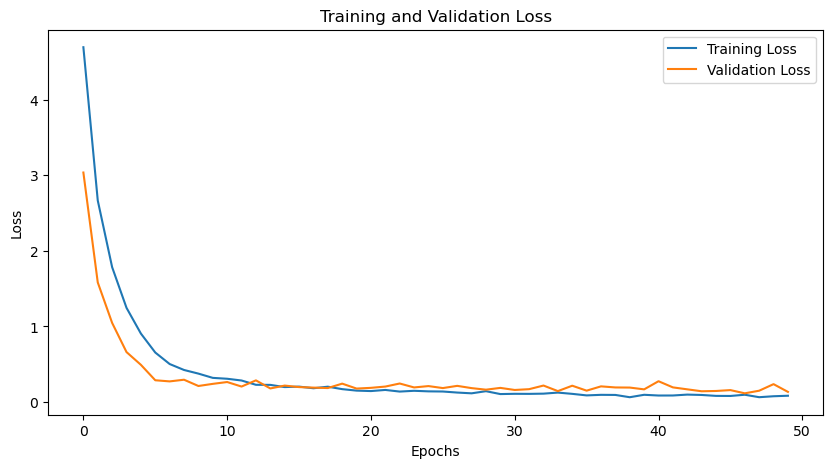

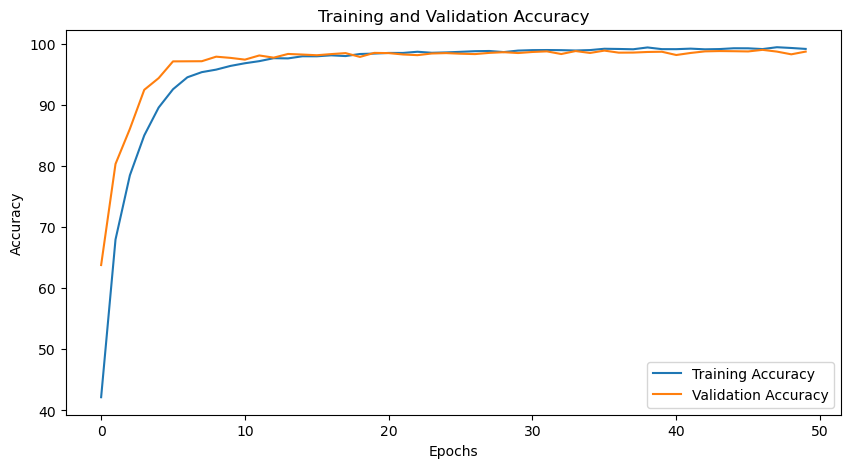

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracies, label='Training Accuracy')
plt.plot(range(num_epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Model Testing

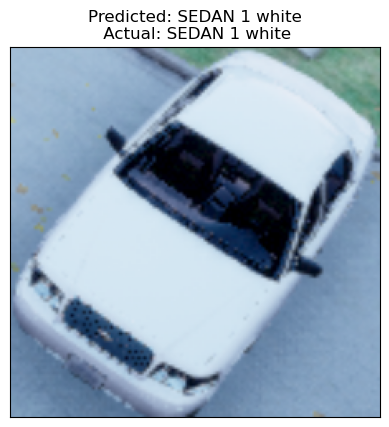

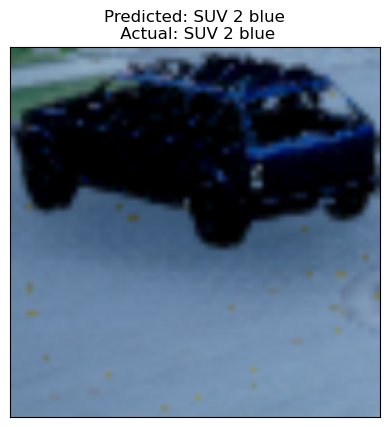

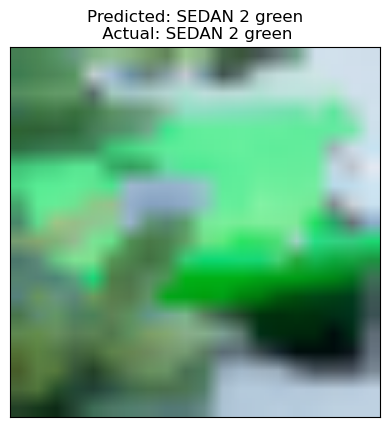

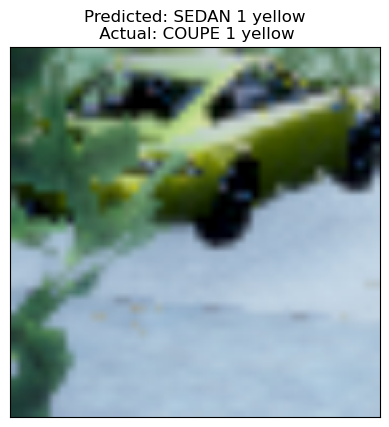

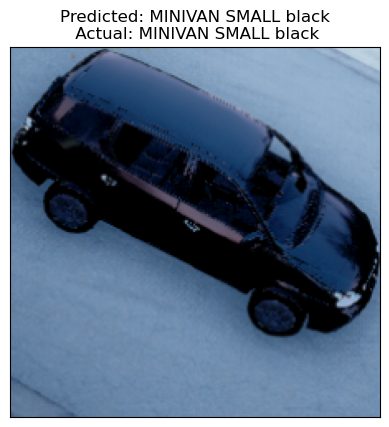

Testing Vehicle Type Accuracy: 98.96%
Testing Vehicle Subtype Accuracy: 98.03%
Testing Vehicle Color Accuracy: 99.59%


In [7]:
#model.load_state_dict(torch.load(os.path.join(current_dir, 'best_model.pth')))
model.eval()
results = []
flag = True

correct_vehicle_type = 0
correct_vehicle_stype = 0
correct_vehicle_color = 0
total = 0

true_vehicle_type_labels = []
true_vehicle_stype_labels = []
true_vehicle_color_labels = []
pred_vehicle_type_labels = []
pred_vehicle_stype_labels = []
pred_vehicle_color_labels = []

with torch.no_grad():
    for images3, labels in dataloaded3:

        images = images3.to(device)
        vehicle_type_labels = labels[0].to(device)
        vehicle_stype_labels = labels[1].to(device)
        vehicle_color_labels = labels[2].to(device)

        outputs = model(images)

        vehicle_type_preds = outputs[:, :len(vt_encoder.classes_)].argmax(dim=1) # 23 different classes, 0-5 are the Types
        vehicle_stype_preds = outputs[:, len(vt_encoder.classes_):len(vt_encoder.classes_) + len(vst_encoder.classes_)].argmax(dim=1) # 6-13 are the Subtypes
        vehicle_color_preds = outputs[:, len(vt_encoder.classes_) + len(vst_encoder.classes_):].argmax(dim=1) # 14-23 are the colors

        true_vehicle_type_labels.extend(vehicle_type_labels.cpu().numpy())
        true_vehicle_stype_labels.extend(vehicle_stype_labels.cpu().numpy())
        true_vehicle_color_labels.extend(vehicle_color_labels.cpu().numpy())

        pred_vehicle_type_labels.extend(vehicle_type_preds.cpu().numpy())
        pred_vehicle_stype_labels.extend(vehicle_stype_preds.cpu().numpy())
        pred_vehicle_color_labels.extend(vehicle_color_preds.cpu().numpy())

        correct_vehicle_type += (vehicle_type_preds == vehicle_type_labels).sum().item()
        correct_vehicle_stype += (vehicle_stype_preds == vehicle_stype_labels).sum().item()
        correct_vehicle_color += (vehicle_color_preds == vehicle_color_labels).sum().item()
        total += vehicle_type_labels.size(0)

        for i in range(images.size(0)):
            vehicle_type = vt_encoder.inverse_transform([vehicle_type_preds[i].item()])[0]
            vehicle_stype = vst_encoder.inverse_transform([vehicle_stype_preds[i].item()])[0]
            vehicle_color = vc_encoder.inverse_transform([vehicle_color_preds[i].item()])[0]
            results.append((vehicle_type, vehicle_stype, vehicle_color))

        if flag is True:
            for i in range(5):
                img = images3[i] * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                img = torch.clamp(img, 0, 1)
                npimg = img.numpy() 
                plt.imshow(np.transpose(npimg, (1, 2, 0)))
                ttypes = vt_encoder.inverse_transform(vehicle_type_labels.cpu().numpy()) 
                tstypes = vst_encoder.inverse_transform(vehicle_stype_labels.cpu().numpy())
                tcol = vc_encoder.inverse_transform(vehicle_color_labels.cpu().numpy())
                ttypes = ttypes[i]
                tstypes = tstypes[i]
                tcol = tcol[i]
                ptypes = results[i][0]
                pstypes = results[i][1]
                pcol = results[i][2]
                plt.xticks([])
                plt.yticks([])
                plt.title(f'Predicted: {ptypes} {pstypes} {pcol}\n Actual: {ttypes} {tstypes} {tcol}')
                plt.show()
                flag = False

vehicle_type_accuracy = correct_vehicle_type / total * 100
vehicle_stype_accuracy = correct_vehicle_stype / total * 100
vehicle_color_accuracy = correct_vehicle_color / total * 100

print(f"Testing Vehicle Type Accuracy: {vehicle_type_accuracy:.2f}%")
print(f"Testing Vehicle Subtype Accuracy: {vehicle_stype_accuracy:.2f}%")
print(f"Testing Vehicle Color Accuracy: {vehicle_color_accuracy:.2f}%")

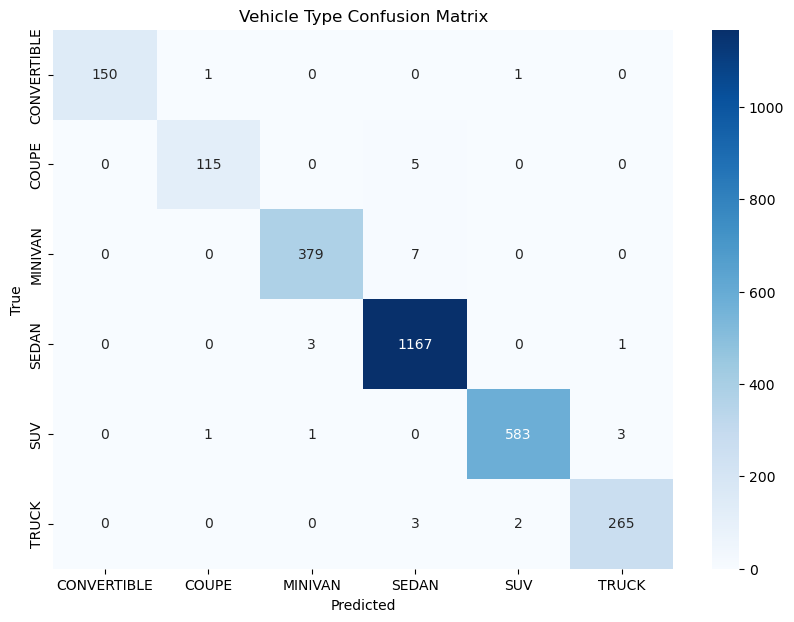

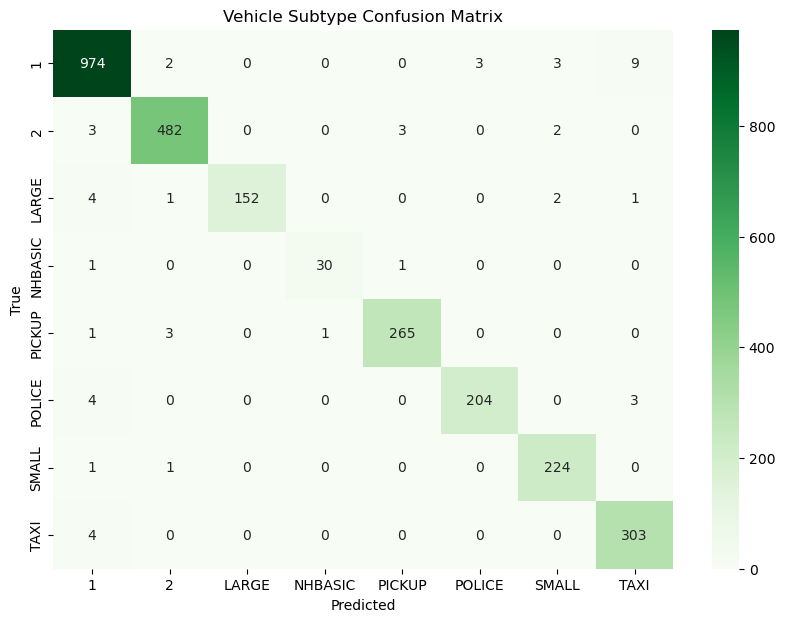

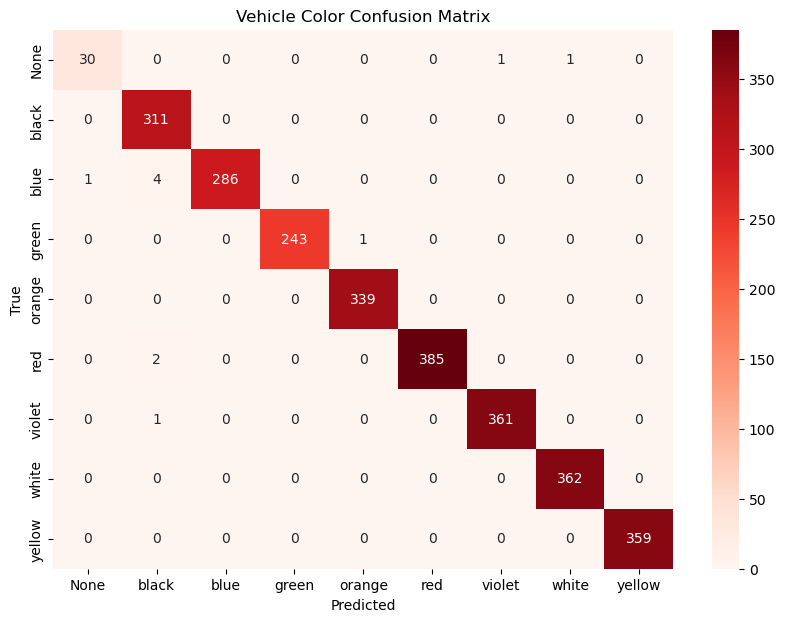

Vehicle Type Classification Report:
              precision    recall  f1-score   support

 CONVERTIBLE       1.00      0.99      0.99       152
       COUPE       0.98      0.96      0.97       120
     MINIVAN       0.99      0.98      0.99       386
       SEDAN       0.99      1.00      0.99      1171
         SUV       0.99      0.99      0.99       588
       TRUCK       0.99      0.98      0.98       270

    accuracy                           0.99      2687
   macro avg       0.99      0.98      0.99      2687
weighted avg       0.99      0.99      0.99      2687

Vehicle Subtype Classification Report:
              precision    recall  f1-score   support

           1       0.98      0.98      0.98       991
           2       0.99      0.98      0.98       490
       LARGE       1.00      0.95      0.97       160
     NHBASIC       0.97      0.94      0.95        32
      PICKUP       0.99      0.98      0.98       270
      POLICE       0.99      0.97      0.98       211
   

In [8]:
true_vehicle_type_labels = np.array(true_vehicle_type_labels)
true_vehicle_stype_labels = np.array(true_vehicle_stype_labels)
true_vehicle_color_labels = np.array(true_vehicle_color_labels)

pred_vehicle_type_labels = np.array(pred_vehicle_type_labels)
pred_vehicle_stype_labels = np.array(pred_vehicle_stype_labels)
pred_vehicle_color_labels = np.array(pred_vehicle_color_labels)

conf_matrix_vehicle_type = confusion_matrix(true_vehicle_type_labels, pred_vehicle_type_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_vehicle_type, annot=True, fmt="d", cmap="Blues", xticklabels=vt_encoder.classes_, yticklabels=vt_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Vehicle Type Confusion Matrix')
plt.show()

conf_matrix_vehicle_stype = confusion_matrix(true_vehicle_stype_labels, pred_vehicle_stype_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_vehicle_stype, annot=True, fmt="d", cmap="Greens", xticklabels=vst_encoder.classes_, yticklabels=vst_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Vehicle Subtype Confusion Matrix')
plt.show()

conf_matrix_vehicle_color = confusion_matrix(true_vehicle_color_labels, pred_vehicle_color_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_vehicle_color, annot=True, fmt="d", cmap="Reds", xticklabels=vc_encoder.classes_, yticklabels=vc_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Vehicle Color Confusion Matrix')
plt.show()

print("Vehicle Type Classification Report:")
print(classification_report(true_vehicle_type_labels, pred_vehicle_type_labels, target_names=vt_encoder.classes_))

print("Vehicle Subtype Classification Report:")
print(classification_report(true_vehicle_stype_labels, pred_vehicle_stype_labels, target_names=vst_encoder.classes_))

print("Vehicle Color Classification Report:")
print(classification_report(true_vehicle_color_labels, pred_vehicle_color_labels, target_names=vc_encoder.classes_))

In [ ]:
#torch.save(best_model_state, 'best_model6.pth')

# things changed for improved model:

# more hidden layers (3 more)
# better dropout value (0.4)
# lowered learning rate & higher weigh decay (0.0002 & 0.0001)
# more data augmentations (introduced random flips)
# longer training (50 epochs)
# added weighted values to features for smarter early stopping (highest weight on subtype)